<a href="https://colab.research.google.com/github/TMhdSofyan/KAUST-Hackathon-EnergyHarvest/blob/main/02_Exercise_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install jcopml

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [19]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [20]:
df_params = pd.read_csv('/content/drive/MyDrive/00_History_Matching/Data/parameters.csv')
df_params.head()

,case_num,category,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
0,0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
1,1,train,96.690954,2216.996775,127.801703,0.265198,672.408364,50.103320
2,2,train,45.990485,1494.508214,321.702554,0.109952,532.563399,73.410282
3,3,train,88.322302,2242.513803,427.275505,0.137530,976.777682,37.443929
4,4,train,27.823837,2994.073285,398.741243,0.220836,465.207942,15.788940


In [21]:
df_prods = pd.read_csv('/content/drive/MyDrive/00_History_Matching/Data/production.csv')
df_prods.head()

,case_num,days,years,oil_prod_rate,oil_prod_cum,water_inj_rate,water_inj_cum
0,0,0,0.000000,0.0,0,0.00,0.0
1,0,31,0.084932,26614.0,825035,1740.71,53962.1
2,0,62,0.169863,21427.7,1489290,1740.71,107924.0
3,0,93,0.254795,18809.7,2072390,1740.71,161886.0
4,0,124,0.339726,16676.6,2589370,1740.71,215848.0


In [22]:
# Concatenate df_params and df_prods based on "case_num"
df = pd.merge(df_prods, df_params, on="case_num")

In [24]:
df.head()

,case_num,days,years,oil_prod_rate,oil_prod_cum,water_inj_rate,water_inj_cum,category,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
0,0,0,0.000000,0.0,0,0.00,0.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
1,0,31,0.084932,26614.0,825035,1740.71,53962.1,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
2,0,62,0.169863,21427.7,1489290,1740.71,107924.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
3,0,93,0.254795,18809.7,2072390,1740.71,161886.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
4,0,124,0.339726,16676.6,2589370,1740.71,215848.0,train,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632


In [ ]:
# Save df
file_path = '/content/drive/MyDrive/00_History_Matching/Data/df_merged.csv'
df.to_csv(file_path, index=False)

In [30]:

for column in df.columns:
    unique_count = df[column].nunique()
    print(f"Number of unique values in column '{column}': {unique_count}")


Number of unique values in column 'case_num': 1000
Number of unique values in column 'days': 121
Number of unique values in column 'years': 121
Number of unique values in column 'oil_prod_rate': 99062
Number of unique values in column 'oil_prod_cum': 105555
Number of unique values in column 'water_inj_rate': 999
Number of unique values in column 'water_inj_cum': 113116
Number of unique values in column 'category': 2
Number of unique values in column 'Kh_Kv': 1000
Number of unique values in column 'inj_rate': 1000
Number of unique values in column 'permeability': 1000
Number of unique values in column 'porosity': 1000
Number of unique values in column 'prod_bhp': 1000
Number of unique values in column 'thickness': 1000


In [34]:
df.columns

Index(['case_num', 'days', 'years', 'oil_prod_rate', 'oil_prod_cum',
       'water_inj_rate', 'water_inj_cum', 'category', 'Kh_Kv', 'inj_rate',
       'permeability', 'porosity', 'prod_bhp', 'thickness'],
      dtype='object')

In [36]:
df.drop(columns=['years', 'oil_prod_rate', 'water_inj_rate', 'water_inj_cum', 'category'], inplace = True)

In [37]:
df.head()

,case_num,days,oil_prod_cum,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness
0,0,0,0,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
1,0,31,825035,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
2,0,62,1489290,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
3,0,93,2072390,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632
4,0,124,2589370,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632


In [39]:
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame named "df"
cases = df['case_num'].unique()

# Initialize empty lists to store the split data
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# Iterate over each unique case_num
for case in cases:
    # Filter the data for the current case_num
    df_case = df[df['case_num'] == case]

    # Split the data for the current case_num
    X = df_case.drop(columns='oil_prod_cum')
    y = df_case['oil_prod_cum']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Append the split data to the respective lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

# Convert the lists to DataFrames
X_train = pd.concat(X_train_list)
X_test = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_test = pd.concat(y_test_list)

# Print the shapes of the split data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (90000, 8)
X_test shape: (31000, 8)
y_train shape: (90000,)
y_test shape: (31000,)


In [42]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gs
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [43]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust', transform='yeo-johnson'), X.columns)
])

from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/jcopml/pipeline/_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 71, 'algo__max_features': 0.6331731119758383, 'algo__min_samples_leaf': 3, 'algo__n_estimators': 200}
0.999900550380952 0.9777230691429848 0.9965596448267091


In [45]:
file_path = '/content/drive/MyDrive/00_History_Matching/Model/model_RF.pkl'

import joblib

# Save the trained model to a file
joblib.dump(model_RF, file_path)

['/content/drive/MyDrive/00_History_Matching/Model/model_RF.pkl']

In [46]:
file_path = '/content/drive/MyDrive/00_History_Matching/Model/model_RF_best_estimator_.pkl'

# Save the trained model to a file
joblib.dump(model_RF.best_estimator_, file_path)

['/content/drive/MyDrive/00_History_Matching/Model/model_RF_best_estimator_.pkl']

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

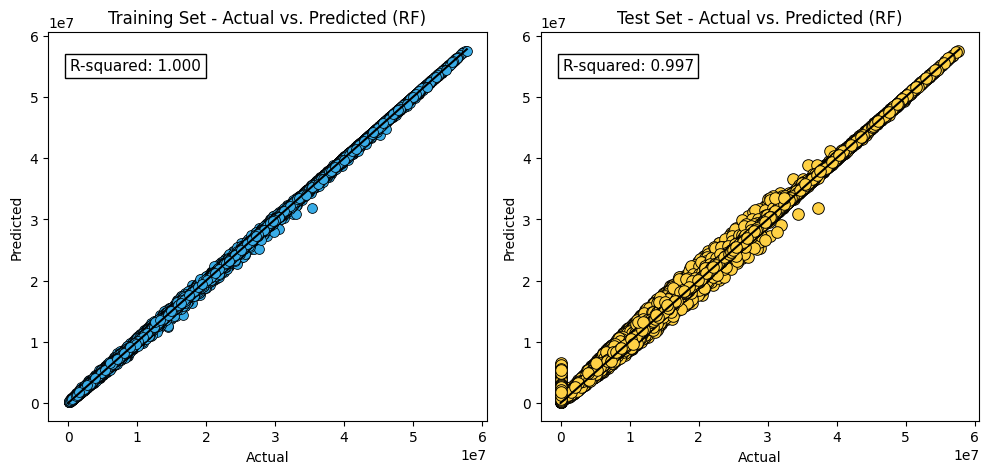

In [60]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (RF)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (RF)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

In [73]:
# Obtain predictions for the test dataset
y_test_pred = model_RF.predict(X_test)

In [87]:
comparison_test_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
comparison_test_df.head()

,Actual,Predicted
44,8003440,7.935746e+06
47,8174680,8.243430e+06
4,2589370,3.311536e+06
55,8624850,8.681777e+06
26,6854360,6.954707e+06


In [88]:
# Concatenate comparison_df with X_test
concatenated_test_df = pd.concat([X_test, comparison_df], axis=1)

concatenated_test_df.head()

,case_num,days,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness,Actual,Predicted
44,0,1364,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,8003440,7.935746e+06
47,0,1457,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,8174680,8.243430e+06
4,0,124,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,2589370,3.311536e+06
55,0,1705,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,8624850,8.681777e+06
26,0,806,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,6854360,6.954707e+06


In [89]:
concatenated_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31000 entries, 44 to 120903
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   case_num      31000 non-null  int64  
 1   days          31000 non-null  int64  
 2   Kh_Kv         31000 non-null  float64
 3   inj_rate      31000 non-null  float64
 4   permeability  31000 non-null  float64
 5   porosity      31000 non-null  float64
 6   prod_bhp      31000 non-null  float64
 7   thickness     31000 non-null  float64
 8   Actual        31000 non-null  int64  
 9   Predicted     31000 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 2.6 MB


In [81]:
# Obtain predictions for the test dataset
y_train_pred = model_RF.predict(X_train)

In [82]:
comparison_train_df = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
comparison_train_df.head()

,Actual,Predicted
78,9904040,9.918775e+06
22,6514170,6.507723e+06
97,10958400,1.096054e+07
56,8680740,8.705013e+06
111,11735100,1.179767e+07


In [90]:
# Concatenate comparison_df with X_test
concatenated_train_df = pd.concat([X_train, comparison_train_df], axis=1)

concatenated_train_df.head()

,case_num,days,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness,Actual,Predicted
78,0,2418,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,9904040,9.918775e+06
22,0,682,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,6514170,6.507723e+06
97,0,3007,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,10958400,1.096054e+07
56,0,1736,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,8680740,8.705013e+06
111,0,3441,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,11735100,1.179767e+07


In [92]:

# Combine the rows of concatenated_train_df and concatenated_test_df
combined_df = pd.concat([concatenated_train_df, concatenated_test_df])

# Reset the index of the combined DataFrame
combined_df = combined_df.reset_index(drop=True)


combined_df.head()

,case_num,days,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness,Actual,Predicted
0,0,2418,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,9904040,9.918775e+06
1,0,682,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,6514170,6.507723e+06
2,0,3007,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,10958400,1.096054e+07
3,0,1736,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,8680740,8.705013e+06
4,0,3441,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,11735100,1.179767e+07


In [ ]:
# Get unique values in the "case_num" column
unique_cases = combined_df['case_num'].unique()

# Initialize an empty DataFrame to store the sorted data
sorted_df = pd.DataFrame()

# Iterate over each unique case_num
for case in unique_cases:
    # Filter the data for the current case_num
    case_data = combined_df[combined_df['case_num'] == case]
    # Sort the data based on the "days" column
    sorted_case_data = case_data.sort_values(by="days")
    # Drop the first row from the sorted data
    sorted_case_data = sorted_case_data.drop(sorted_case_data.index[0])
    # Append the sorted data to the overall sorted DataFrame
    sorted_df = sorted_df.append(sorted_case_data, ignore_index=True)

# Print the updated dataset
print(sorted_df)

In [135]:
sorted_df[sorted_df['case_num'] == 0]

,case_num,days,Kh_Kv,inj_rate,permeability,porosity,prod_bhp,thickness,Actual,Predicted
0,0,31,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,825035,8.965584e+05
1,0,62,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,1489290,1.582207e+06
2,0,93,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,2072390,2.090354e+06
3,0,124,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,2589370,3.311536e+06
4,0,155,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,3048500,3.311536e+06
...,...,...,...,...,...,...,...,...,...,...
115,0,3596,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,12012500,1.204226e+07
116,0,3627,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,12068000,1.205924e+07
117,0,3658,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,12123500,1.207500e+07
118,0,3689,16.423475,1740.711355,288.983333,0.163009,796.992254,23.718632,12179000,1.207500e+07


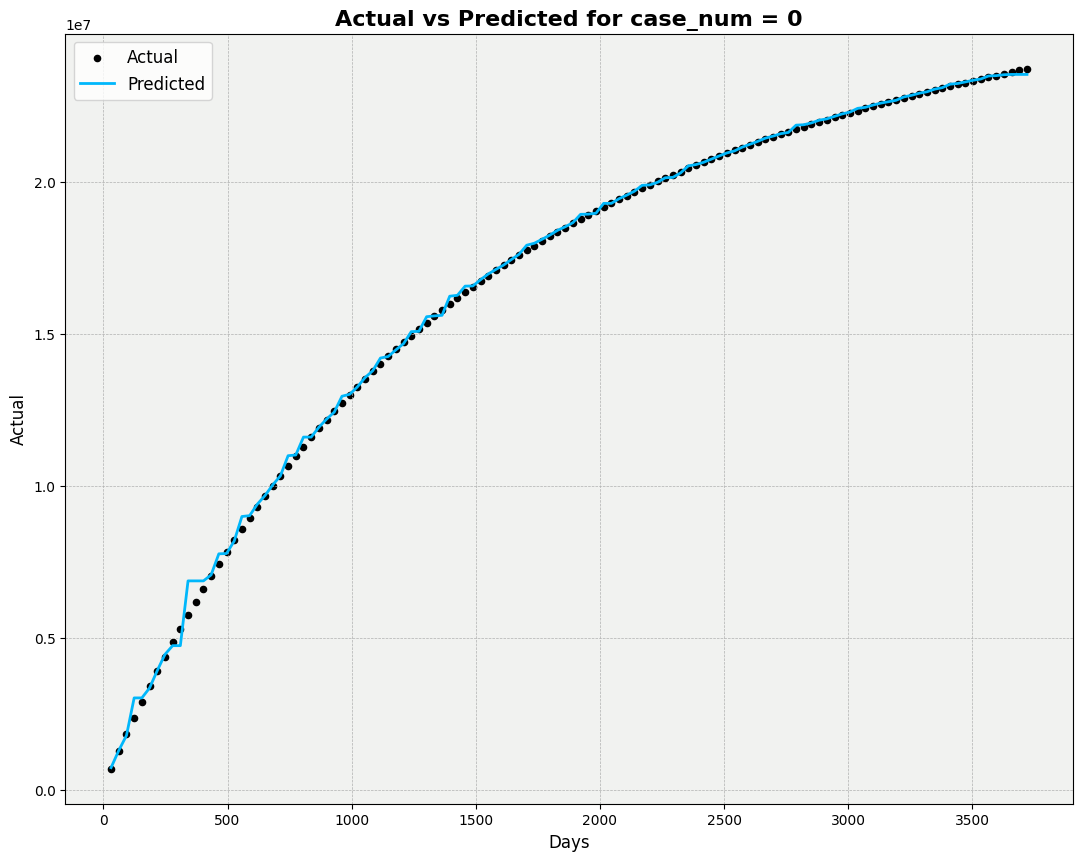

In [161]:
plot_1 = sorted_df[sorted_df['case_num'] == 10]

# Create the line plot
fig, ax1 = plt.subplots(figsize=(13, 10))

# Plot scatter for "Actual" column
ax1.scatter(plot_1['days'], plot_1['Actual'], color='black', s=20, label='Actual', marker='o')

# Plot line for "Predicted" column
ax1.plot(plot_1['days'], plot_1['Predicted'], color='#00b7fb', linewidth=2, label='Predicted')

ax1.set_xlabel('Days', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)

# Add gridlines
ax1.grid(True, linestyle='--', linewidth=0.5)

# Customize the title font size and style
plt.title('Actual vs Predicted for case_num = 0', fontsize=16, fontweight='bold')

# Customize the legend font size
plt.legend(loc='upper left', fontsize=12)

# Customize the tick label font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a background color
ax1.set_facecolor('#F1F2F0')

plt.show()


In [ ]:
# Get unique values in the "case_num" column
unique_cases = sorted_df['case_num'].unique()

# Iterate over each unique case_num
for case in unique_cases:
    # Filter the data for the current case_num
    case_data = sorted_df[sorted_df['case_num'] == case]
    
    # Create a new figure for each case_num
    fig, ax1 = plt.subplots(figsize=(13, 10))
    
    # Plot scatter for "Actual" column
    ax1.scatter(case_data['days'], case_data['Actual'], s=10, color='#39ACE7', label='Actual')
    
    # Plot line for "Predicted" column
    ax1.plot(case_data['days'], case_data['Predicted'], color='black', label='Predicted')

    ax1.set_xlabel('Days', fontsize=12)
    ax1.set_ylabel('Actual', fontsize=12)

    # Add gridlines
    ax1.grid(True, linestyle='--', linewidth=0.5)

    # Customize the title font size and style
    plt.title(f'Actual vs Predicted for case_num = {case}', fontsize=16, fontweight='bold')

    # Customize the legend font size
    plt.legend(loc='upper left', fontsize=12)

    # Customize the tick label font size
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Add a background color
    ax1.set_facecolor('#F1F2F0')

    plt.show()